In [42]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../train')

import model.models as models
from model.datamodule import MyDataModule
from model.datamodule import MyDataModuleWithRoute
import mylib.route as m_route
import mylib.utils as ut
import mylib.config as conf

In [43]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DF_PATH = os.path.join(ROOT_PATH, "data", "df_test.pickle")
OUTPUT_DIR = os.path.join(ROOT_PATH, "out")
CONFIG_DIR = os.path.join(ROOT_PATH, "config")

In [44]:
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-08-22-23-36-input_zeros")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-08-21-18-50-mag")
cp_path = os.path.join(log_dir, "cp/last.ckpt")
config_path = os.path.join(log_dir, "config.yaml")

In [45]:
def plot_route(y, y_hat):
    plt.figure(figsize=(4, 10))
    plt.plot(y[0, :, 0], y[0, :, 1], marker="o")
    plt.plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()

In [46]:
def plot_route2(x, y, y_hat):
    # 2つのルートをプロット
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(x[0, :, 3], x[0, :, 4], marker="o")
    ax[1].plot(y[0, :, 0], y[0, :, 1], marker="o", label="true")
    ax[1].plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x", label="pred")
    ax[1].set_xlim(0, 3.5)
    ax[1].set_ylim(0, 11)
    ax[1].legend()
    plt.show()

In [47]:
def get_random_noise(mean, std, shape):
    # ランダムノイズを生成
    random_noise = torch.normal(mean=mean, std=std, size=shape)
    # random_noise = torch.empty(x.shape[0], x.shape[1]).uniform_(-0.5, 0.5)
    return random_noise

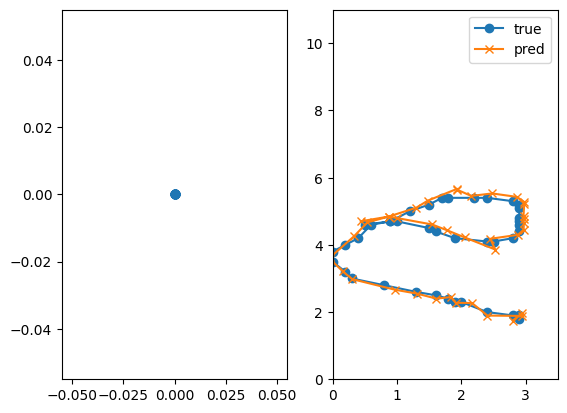

[[0.11962292 0.14428551 0.14456344 0.12016883 0.35782826 0.2758876
  0.0727425  0.15234092 0.14274357 0.10908335 0.1339312  0.08863637
  0.10773392 0.07590453 0.0884482  0.12784187 0.09576271 0.26981747
  0.15226185 0.18646279 0.11628355 0.0989532  0.14428551 0.09130618
  0.08885643 0.43539196 0.06096273 0.08634044 0.04104024 0.01944687
  0.21585879 0.05303596 0.10173621 0.06026779 0.02661534 0.16746026
  0.10381529 0.13999628 0.07709177 0.11754661]]
0.13030897


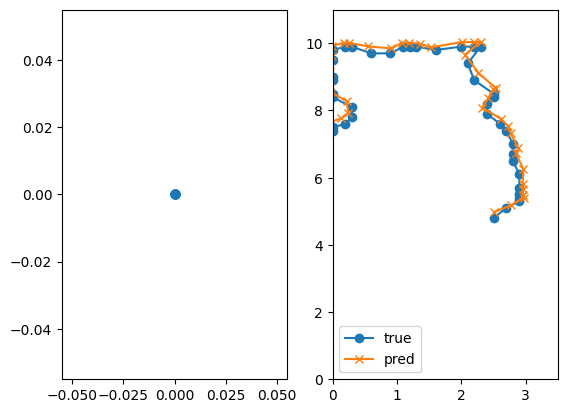

[[0.17861915 0.099202   0.12000466 0.09493375 0.18186335 0.1163824
  0.16538306 0.2280794  0.1980761  0.31902805 0.13400038 0.1490045
  0.19765525 0.16089043 0.23791505 0.16581795 0.2267192  0.2696401
  0.14481674 0.13696672 0.13568434 0.10941501 0.10241307 0.11449961
  0.11799453 0.14872438 0.20995855 0.12003937 0.12031933 0.12065709
  0.1274725  0.1461571  0.14814244 0.1639457  0.1630077  0.19240499
  0.14944507 0.1777069  0.15221076 0.1672078 ]]
0.1603101


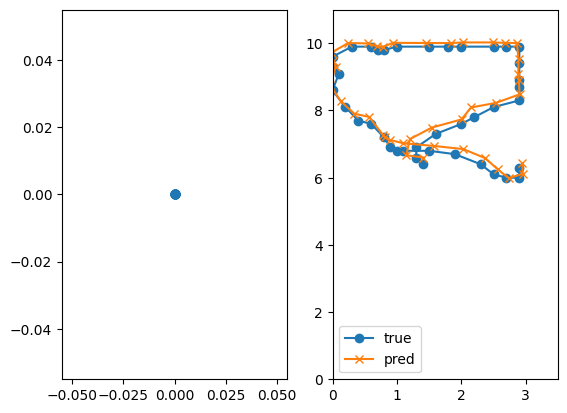

[[0.20050403 0.17032987 0.26725003 0.19992171 0.13415894 0.29336718
  0.13390343 0.18050517 0.21523997 0.18876353 0.13223025 0.11416166
  0.11381197 0.1253715  0.12627178 0.11083726 0.116971   0.12941256
  0.09163362 0.10739584 0.10726161 0.12215843 0.1239516  0.16088645
  0.20557372 0.15728042 0.18476988 0.21168084 0.21124664 0.08156368
  0.30920333 0.3364775  0.22410308 0.16100772 0.19971119 0.19337775
  0.16217196 0.03836467 0.12801462 0.13547125]]
0.16515794


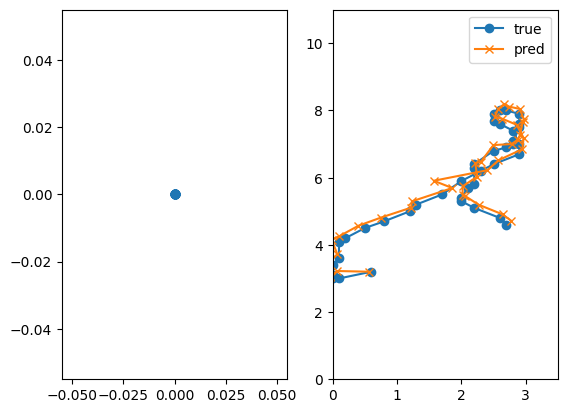

[[0.02955678 0.22520399 0.05219357 0.04493924 0.11059668 0.12530781
  0.1261525  0.11053452 0.11984962 0.12287078 0.10966907 0.11686975
  0.24930297 0.42807725 0.10681192 0.13994226 0.15811202 0.19521728
  0.18451719 0.160168   0.10718786 0.16918765 0.1989551  0.12274488
  0.14647675 0.16474675 0.16681445 0.19895604 0.15304902 0.12898138
  0.17009366 0.12287421 0.13171896 0.23506369 0.09089384 0.09437913
  0.16140482 0.11745446 0.11532549 0.13725062]]
0.1462363


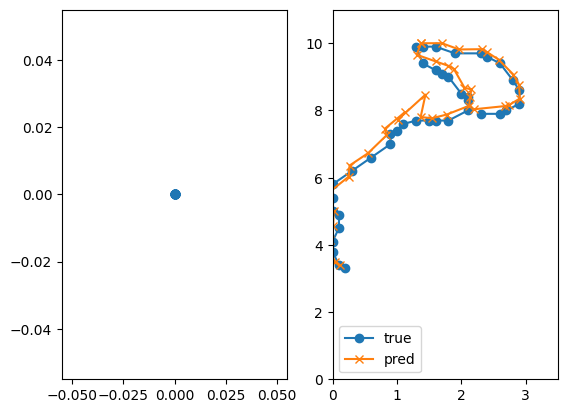

[[0.12924796 0.10956586 0.06997135 0.07527656 0.10418881 0.12515573
  0.10792372 0.15233755 0.34332898 0.16546994 0.13750607 0.26665875
  0.1815357  0.5635839  0.15355916 0.78568536 0.16866498 0.08960685
  0.18021952 0.14395973 0.10962629 0.2333736  0.18343592 0.25605977
  0.24915506 0.25798073 0.27546272 0.12279326 0.10512477 0.14162482
  0.13327053 0.12597829 0.13158141 0.11327731 0.16734481 0.16615473
  0.15594627 0.16602935 0.24276069 0.17121902]]
0.18904115


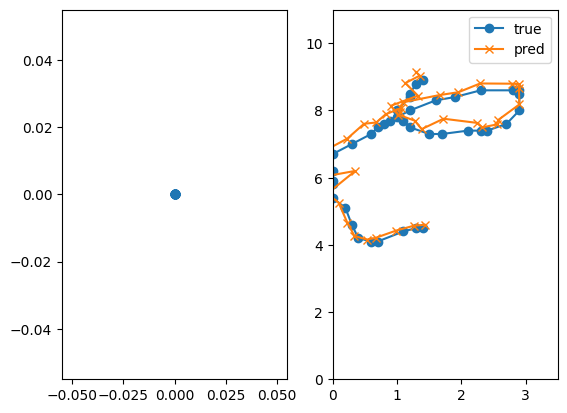

[[0.10230539 0.07991773 0.1137964  0.11328291 0.08765372 0.09005198
  0.09318145 0.18303451 0.15370207 0.5349683  0.1709819  0.17390127
  0.16672103 0.17896175 0.3235921  0.14493263 0.28740412 0.40625626
  0.17152864 0.26500267 0.17023659 0.15298983 0.20422748 0.19719443
  0.18531048 0.16254188 0.17973444 0.17416553 0.24152744 0.10119636
  0.2724249  0.45514396 0.18580861 0.21065016 0.19424507 0.168696
  0.13187696 0.32412034 0.24442995 0.2723692 ]]
0.20175166


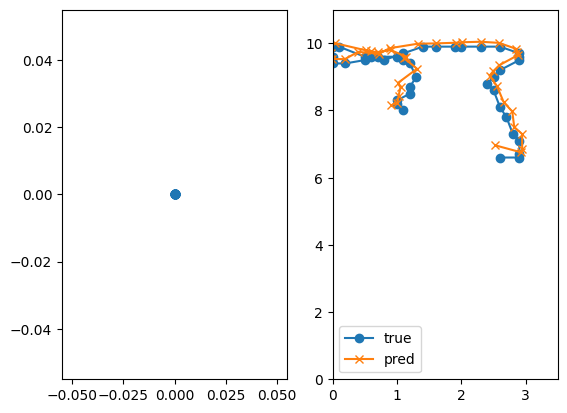

[[0.3687571  0.15649459 0.15914562 0.20385157 0.2072878  0.1936054
  0.15589032 0.14275801 0.23606423 0.16330282 0.1478752  0.14980341
  0.14199646 0.139882   0.11299669 0.14551996 0.13112499 0.11785296
  0.09796702 0.11586349 0.2628075  0.20190273 0.26582262 0.12890741
  0.13317747 0.12630142 0.10061079 0.1130912  0.1915238  0.15571867
  0.13758305 0.22276601 0.10970937 0.1984626  0.24194176 0.2200978
  0.23403443 0.14682241 0.02942382 0.24385335]]
0.16881494


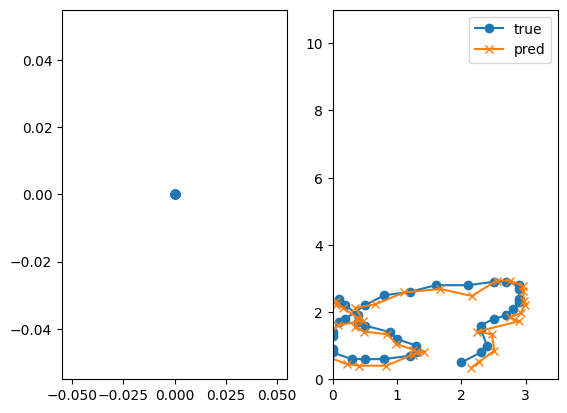

[[0.08110984 0.08884162 0.0792919  0.06471145 0.15061697 0.17898871
  0.07911243 0.14832607 0.12822825 0.08496097 0.12896279 0.05429613
  0.19957688 0.2150811  0.16704348 0.1569054  0.10612359 0.12240884
  0.11508555 0.096237   0.27968067 0.16255905 0.3027064  0.09279436
  0.1305604  0.3279801  0.05905369 0.06831907 0.0688601  0.09515301
  0.10061952 0.12180998 0.17803009 0.07845086 0.39501587 0.1946964
  0.23499435 0.18522884 0.27806723 0.21985115]]
0.1505085


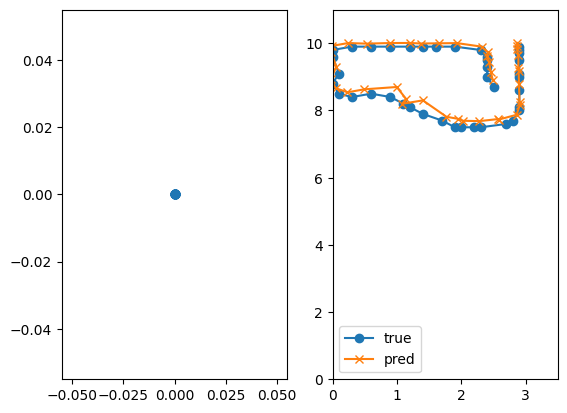

[[0.20711832 0.15051153 0.14174034 0.13065141 0.12994494 0.10077389
  0.1098449  0.10909301 0.09909528 0.11007176 0.1072837  0.1111442
  0.12258046 0.12062772 0.12780088 0.20551853 0.14532778 0.17578201
  0.1566899  0.16699292 0.3140254  0.15258692 0.15423879 0.40094548
  0.1317149  0.25572845 0.19514693 0.1988098  0.36113563 0.17607033
  0.18134564 0.17434011 0.14688827 0.18420392 0.17339042 0.17302214
  0.13827829 0.13679281 0.13344945 0.11888641]]
0.16573983


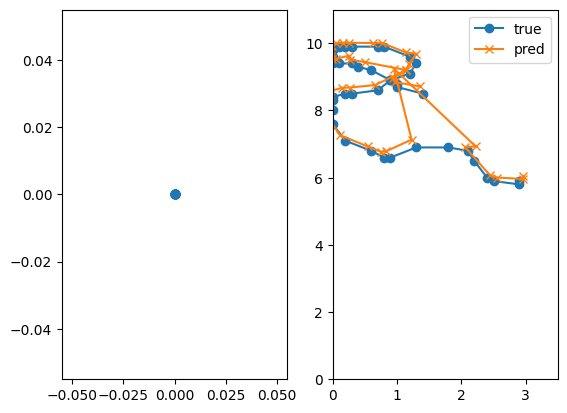

[[0.220126   0.14894493 0.16995597 0.38745892 0.25395444 0.25033796
  0.23635268 0.1412822  0.13668492 0.13243133 0.1299926  0.12666668
  0.11050098 0.11847993 0.12103461 0.12692274 0.11290238 0.14393872
  0.28533468 0.28850183 0.38745892 0.16194502 0.18490231 0.18205555
  0.18147077 0.1823107  0.19110093 0.16527516 0.18711245 0.13895804
  0.17609754 0.19854914 0.244487   2.4955485  0.1771862  0.44053262
  0.08261679 0.11954705 0.1692128  0.16306141]]
0.24678084


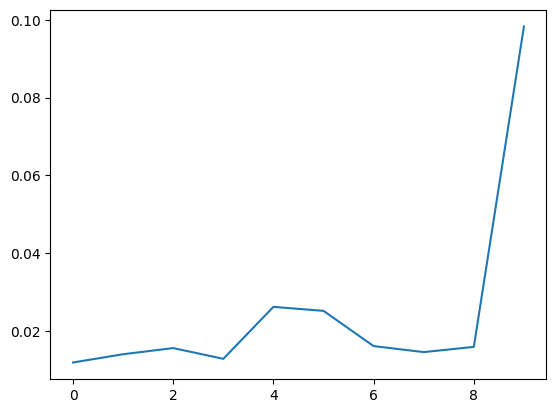

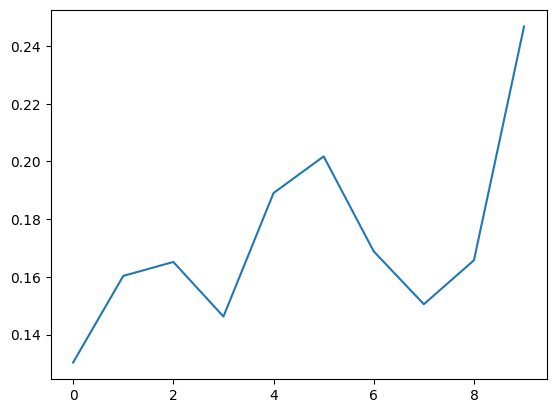

0.025022680312395094


In [48]:

ut.fix_seeds(0)

config = conf.from_yaml(config_path)

df = pickle.load(open(DF_PATH, "rb"))
    
config = conf.from_yaml(config_path)

config_route = config["route"]
route_gen = m_route.DistanceRotateRouteGeneraterV1.from_config(config_route)

config_dm = config["dm"]
dm = MyDataModuleWithRoute(n_of_route=config_dm["n_of_route"], batch_size=config_dm["batch_size"], route_gen=route_gen, df=df)
# dm = MyDataModule(n_of_route=config_dm["n_of_route"], batch_size=config_dm["batch_size"], route_gen=route_gen, df=df)


model = models.TransformerWithRoute.load_from_checkpoint(cp_path)
# model = models.TransformerByPL.load_from_checkpoint(cp_path)
model.eval()


loss_list = []
dist_list = []
for i in range(10):
    # batch = dm.train_dataset[i]
    batch = dm.val_dataset[i]
    # batch = dm.test_dataset[i]
    x, y = batch
    x = x.unsqueeze(0)

    mean = 0.0  # 平均
    std = 0.381  # 標準偏差
    
    # x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1]))
    # x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1]))
    # x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1]))

    y = y.unsqueeze(0)
    y_hat = model(x.cuda())
    # print(x)
    # print(y)
    # print(y_hat)

    loss = nn.functional.mse_loss(y_hat, y.cuda())
    # print(loss)
    loss_list.append(loss.item())

    x = x.cpu().detach().numpy()
    y_hat = y_hat.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    plot_route2(x, y, y_hat)
    # plot_route(y, y_hat)

    dist_errors = np.linalg.norm(y - y_hat, axis=-1)
    print(dist_errors)
    dist_mean = np.mean(dist_errors)
    
    dist_list.append(dist_mean)  
    print(dist_mean)
    

plt.plot(loss_list)
plt.show()

plt.plot(dist_list)
plt.show()

avg = sum(loss_list) / len(loss_list)
print(avg)


In [49]:
# loss = nn.functional.mse_loss(y_hat, y[:,-1,:].cuda())
print(loss)

plt.figure(figsize=(3, 9))

dist_hist = []

for i in range(len(y)):
    x_s = [y[i, -1, 0].cpu().numpy(), y_hat[i, 0].detach().cpu().numpy()]
    y_s = [y[i, -1, 1].cpu().numpy(), y_hat[i, 1].detach().cpu().numpy()]

    

    dist = pow(pow(x_s[0] - x_s[1], 2) + pow(y_s[0] - y_s[1], 2), 0.5)
    dist_hist.append(dist)

    plt.plot(x_s, y_s, marker="o")


plt.xlim(0, 3)
plt.ylim(0, 10)
plt.show()


plt.hist(dist_hist, bins=30)
plt.show()

tensor(0.0983, device='cuda:0', grad_fn=<MseLossBackward0>)


AttributeError: 'numpy.float32' object has no attribute 'cpu'

<Figure size 300x900 with 0 Axes>

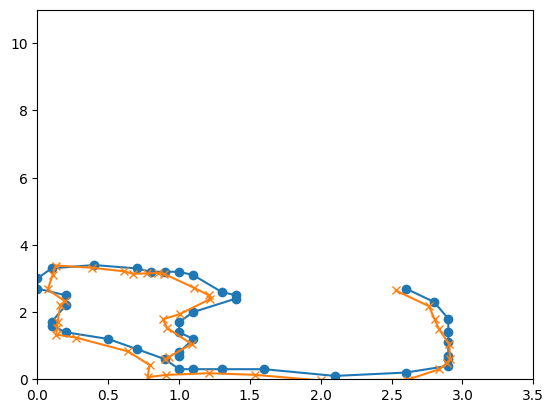

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
for i in range(10):
    plt.plot(y[i, :, 0], y[i, :, 1], marker="o")
    plt.plot(y_hat[i, :, 0], y_hat[i, :, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()